# Evento 5-10-2018 - Style Transfer

## Objetivos

Lograr capturar la esencia (o "contenido") de una imagen, para luego ser re-pintada utilizando un "estilo" capturado de otra imagen (o pintura).

## Requerimientos

Utilizar el contenedor Docker que hemos preparado.

## Framework

Vamos a emplear el framework Keras para la ejecución del modelo.
Utilizaremos una red neuronal entrenada: VGG-16.

## Opcion 1: Imagen Docker

Para simplificar el trabajo, hemos creado una imagen docker en Docker Hub. Para ejecutarla debemos seguir los siguientes pasos:

1. Descargar e instalar Docker
2. Ejecutar el siguiente comando desde Terminal o CMD: "docker pull farreg/schoolofaibsas"
3. Ejecutar: "docker image ls"
4. Reconocer la imagen que dice "farreg/schoolofaibsas" y obtener su IMAGE ID
5. Ejecutar: "docker run -it -p 8888:8888 XXXX", donde XXXX es el IMAGE ID.

A partir de aquí podrán seguir el Online Coding Session paso a paso.

## Opcion 2: Anaconda

Ejecutar el comando:

```
python -m pip install --upgrade pip
```

Y luego ejecutar:

```
pip install --ignore-installed --user -r requirements.txt
```

## Ejemplos de Style Transfer

### Contenido: Gato

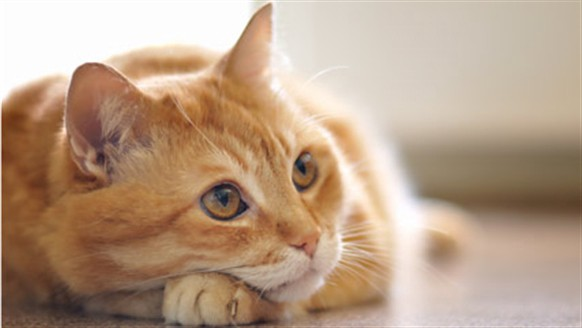

### Estilo: Violin on Palette (Braque)

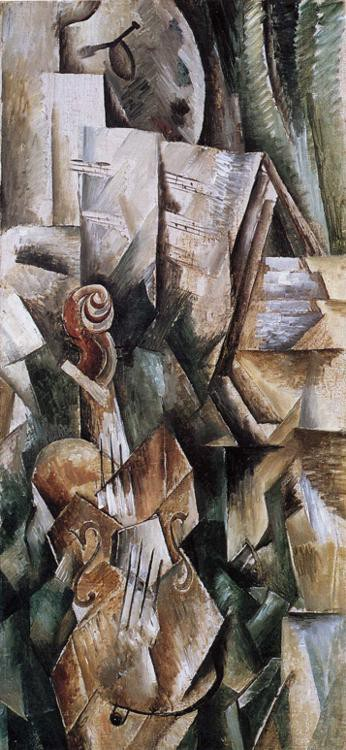

### Resultado: Gato Cubista

![Alt text](./examples/cubist_cat.png?raw=true "Cubist Cat")

### Otro ejemplo:

### Contenido: Hall

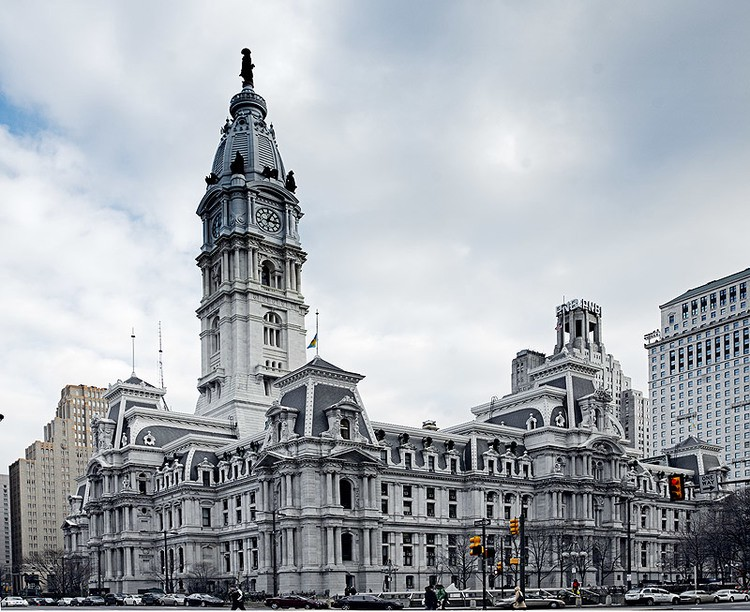

### Estilo: Starry Night Over the Rhone (Van Gogh)

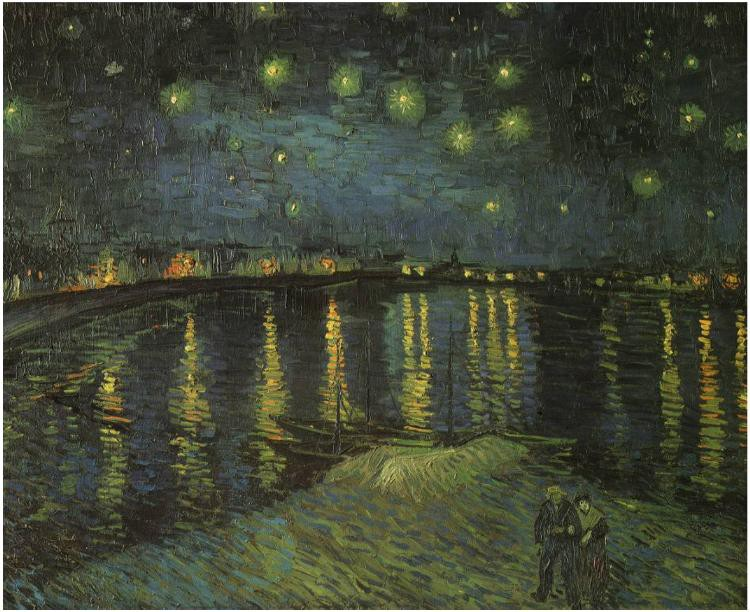

### Resultado: Starry Hall

![Alt text](./examples/starry_hall.jpg?raw=true "Starry Hall")


# Un poco de Álgebra...


## Función de Pérdida para alimentar nuestro modelo neuronal

### Separamos en 2 partes la función de pérdida total: Contenido y Estilo.

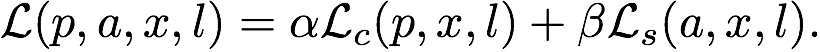

### Alfa y Beta son parámetros empíricos que permiten darle mayor o menor importancia al contenido o al estilo respectivamente.

## Función de Pérdida de Contenido

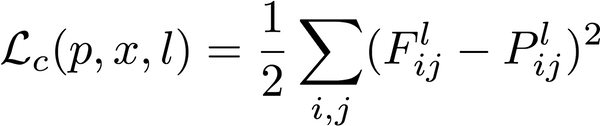

### Se compara la imagen generada en cada capa contra la imagen original en cada capa. De esa manera si la imagen generada difiere en gran medida de la original, tendremos un alto valor de perdida de contenido.

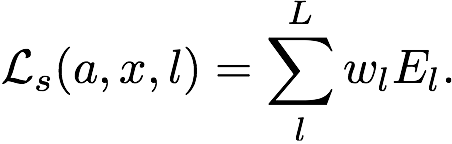

### Omega (w) es la importancia del estilo aportado por cada capa. Cuanto mayor la profundidad de la capa, mayor la abstracción del estilo.

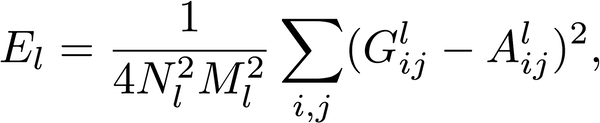

### Para el cálculo de estilo utilizamos la matriz de Gram.

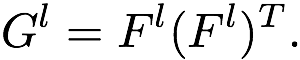

In [3]:
from IPython.display import HTML
HTML('<div style="width:100%;height:0;padding-bottom:56%;position:relative;"><iframe src="https://giphy.com/embed/9Af093GLwlBNm" width="100%" height="100%" style="position:absolute" frameBorder="0" class="giphy-embed" allowFullScreen></iframe></div><p><a href="https://giphy.com/gifs/bc-9Af093GLwlBNm">via GIPHY</a></p>')

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input
from scipy.optimize import fmin_l_bfgs_b
import time

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
## Specify paths for 1) content image 2) style image and 3) generated image (DON'T PUT EXTENSION FOR OUTPUT IMAGE)
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##

cImPath = './input/1.jpg'
sImPath = './styles/1.jpg'
genImOutputPath = './output/1'

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
## Image processing
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
targetHeight = 512
targetWidth = 512
targetSize = (targetHeight, targetWidth)

cImageOrig = Image.open(cImPath)
cImageSizeOrig = cImageOrig.size
cImage = load_img(path=cImPath, target_size=targetSize)
cImArr = img_to_array(cImage)
cImArr = K.variable(preprocess_input(np.expand_dims(cImArr, axis=0)), dtype='float32')

sImage = load_img(path=sImPath, target_size=targetSize)
sImArr = img_to_array(sImage)
sImArr = K.variable(preprocess_input(np.expand_dims(sImArr, axis=0)), dtype='float32')

gIm0 = np.random.randint(256, size=(targetWidth, targetHeight, 3)).astype('float64')
gIm0 = preprocess_input(np.expand_dims(gIm0, axis=0))

gImPlaceholder = K.placeholder(shape=(1, targetWidth, targetHeight, 3))

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
## Define loss and helper functions
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##

def get_feature_reps(x, layer_names, model):
    featMatrices = []
    for ln in layer_names:
        selectedLayer = model.get_layer(ln)
        featRaw = selectedLayer.output
        featRawShape = K.shape(featRaw).eval(session=tf_session)
        N_l = featRawShape[-1]
        M_l = featRawShape[1]*featRawShape[2]
        featMatrix = K.reshape(featRaw, (M_l, N_l))
        featMatrix = K.transpose(featMatrix)
        featMatrices.append(featMatrix)
    return featMatrices

def get_content_loss(F, P):
    cLoss = 0.5*K.sum(K.square(F - P))
    return cLoss

def get_Gram_matrix(F):
    G = K.dot(F, K.transpose(F))
    return G

def get_style_loss(ws, Gs, As):
    sLoss = K.variable(0.)
    for w, G, A in zip(ws, Gs, As):
        M_l = K.int_shape(G)[1]
        N_l = K.int_shape(G)[0]
        G_gram = get_Gram_matrix(G)
        A_gram = get_Gram_matrix(A)
        sLoss = sLoss + w*0.25*K.sum(K.square(G_gram - A_gram))/ (N_l**2 * M_l**2)
    return sLoss

def get_total_loss(gImPlaceholder, alpha=1.0, beta=10000.0):
    F = get_feature_reps(gImPlaceholder, layer_names=[cLayerName], model=gModel)[0]
    Gs = get_feature_reps(gImPlaceholder, layer_names=sLayerNames, model=gModel)
    contentLoss = get_content_loss(F, P)
    styleLoss = get_style_loss(ws, Gs, As)
    totalLoss = alpha*contentLoss + beta*styleLoss
    return totalLoss


def calculate_loss(gImArr):
    """
    Calculate total loss using K.function
    """
    if gImArr.shape != (1, targetWidth, targetHeight, 3):
        gImArr = gImArr.reshape((1, targetWidth, targetHeight, 3))
    loss_fcn = K.function([gModel.input], [get_total_loss(gModel.input)])
    return loss_fcn([gImArr])[0].astype('float64')


def get_grad(gImArr):
    """
    Calculate the gradient of the loss function with respect to the generated image
    """
    if gImArr.shape != (1, targetWidth, targetHeight, 3):
        gImArr = gImArr.reshape((1, targetWidth, targetHeight, 3))
    grad_fcn = K.function([gModel.input], K.gradients(get_total_loss(gModel.input), [gModel.input]))
    grad = grad_fcn([gImArr])[0].flatten().astype('float64')
    return grad

def postprocess_array(x):
    # Zero-center by mean pixel
    if x.shape != (targetWidth, targetHeight, 3):
        x = x.reshape((targetWidth, targetHeight, 3))
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    # 'BGR'->'RGB'
    x = x[..., ::-1]
    x = np.clip(x, 0, 255)
    x = x.astype('uint8')
    return x


def reprocess_array(x):
    x = np.expand_dims(x.astype('float64'), axis=0)
    x = preprocess_input(x)
    return x

def save_original_size(x, target_size=cImageSizeOrig):
    xIm = Image.fromarray(x)
    xIm = xIm.resize(target_size)
    xIm.save(genImOutputPath + '.{}.jpg'.format(time.time()))
    return xIm

def save_mid_image(x):
    xOut = postprocess_array(x)
    xIm = save_original_size(xOut)
    print('Image saved')
    end = time.time()
    print('Time taken: {}'.format(end-start))


tf_session = K.get_session()
cModel = VGG16(include_top=False, weights='imagenet', input_tensor=cImArr)
sModel = VGG16(include_top=False, weights='imagenet', input_tensor=sImArr)
gModel = VGG16(include_top=False, weights='imagenet', input_tensor=gImPlaceholder)
cLayerName = 'block4_conv2'
sLayerNames = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                #'block5_conv1'
                ]


P = get_feature_reps(x=cImArr, layer_names=[cLayerName], model=cModel)[0]
As = get_feature_reps(x=sImArr, layer_names=sLayerNames, model=sModel)
ws = np.ones(len(sLayerNames))/float(len(sLayerNames))

iterations = 600
x_val = gIm0.flatten()
start = time.time()

xopt, f_val, info= fmin_l_bfgs_b(calculate_loss, x_val, fprime=get_grad, 
    maxiter=iterations, disp=True, callback=save_mid_image)


In [ ]:
import cv2
import os

def make_video(image_folder, outvid=None, fps=5, size=None,
               is_color=True, format="MP4V"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    images = [imag for imag in os.listdir(image_folder) if imag.endswith(".jpg")]
    for image in images:
        if not os.path.exists(image_folder + '/' + image):
            raise FileNotFoundError(image)
        img = imread(image_folder + '/' + image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

image_folder = 'output'
video_name = 'video.mp4'

make_video(image_folder, video_name, 20)